In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt
from dagger.graph import DAG, _calc_prior_discrete, _group_probs
from dagger.common import make_fake_df, normalise

In [3]:
df = pd.DataFrame({"a": [1, 1, 1, 1, 0, 0, 0, 0], 
                   "b": [0, 1, 0, 1, 1, 1, 1, 0], 
                   "c": [0, 0, 1, 0, 0, 1, 0, 1],
                   "d": [1, 1, 0, 1, 0, 0, 0, 0],
                   "e": [1, 1, 1, 1, 0, 0, 0, 0]})
dag = DAG(df).add_edge("a", "b").add_edge("a", "c").add_edge("c", "b")

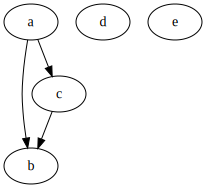

In [4]:
dag.plot()

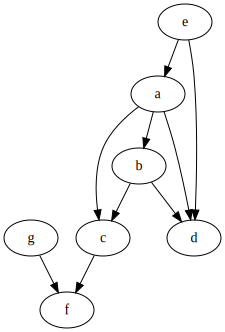

In [5]:
dag = (DAG(make_fake_df(7))
       .add_edge("e", "a")
       .add_edge("e", "d")
       .add_edge("a", "d")
       .add_edge("b", "d")
       .add_edge("a", "b")
       .add_edge("a", "c")
       .add_edge("b", "c")
       .add_edge("c", "f")
       .add_edge("g", "f"))

dag.plot()